<a href="https://colab.research.google.com/github/AUT-Student/NN-HW8/blob/main/NN_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source

https://www.tensorflow.org/text/tutorials/transformer

# Library

In [1]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 31.2 MB/s 
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 5.8 MB 59.3 MB/s 
     |████████████████████████████████| 1.6 MB 45.8 MB/s 
     |████████████████████████████████| 438 kB 20.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_text

from keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Layer
from keras.models import Sequential 

# Dataset

In [3]:
dataset = tfds.load('ted_hrlr_translate/pt_to_en', with_info=False, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQQTIYX/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQQTIYX/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteQQTIYX/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]
valid_dataset = dataset["validation"]

In [5]:
for i, data in enumerate(train_dataset):
  print(f"i = {i}")
  print(data[0])
  print(data[1])
  
  if i>5: break

i = 0
tf.Tensor(b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .', shape=(), dtype=string)
tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)
i = 1
tf.Tensor(b'mas e se estes fatores fossem ativos ?', shape=(), dtype=string)
tf.Tensor(b'but what if it were active ?', shape=(), dtype=string)
i = 2
tf.Tensor(b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .', shape=(), dtype=string)
tf.Tensor(b"but they did n't test for curiosity .", shape=(), dtype=string)
i = 3
tf.Tensor(b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .', shape=(), dtype=string)
tf.Tensor(b'and this conscious defiance is why i , as an agnostic , can still have faith .', shape=(), dtype=string)
i = 4
tf.Tensor(b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''", shape=()

# Tokenization

In [6]:
tokenizers_model_name = 'ted_hrlr_translate_pt_en_converter'
keras.utils.get_file(
    f'{tokenizers_model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{tokenizers_model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(tokenizers_model_name)
en_tokenizer = tokenizers.en
pt_tokenizer = tokenizers.pt

# Batching

In [8]:
en_length_list = np.zeros(0)
pt_length_list = np.zeros(0)
for pt_data, en_data in train_dataset.batch(4*1024):
  new_en_length_list = en_tokenizer.tokenize(en_data).row_lengths().numpy()
  new_pt_length_list = pt_tokenizer.tokenize(pt_data).row_lengths().numpy()

  en_length_list = np.concatenate((en_length_list, new_en_length_list))
  pt_length_list = np.concatenate((pt_length_list, new_pt_length_list))

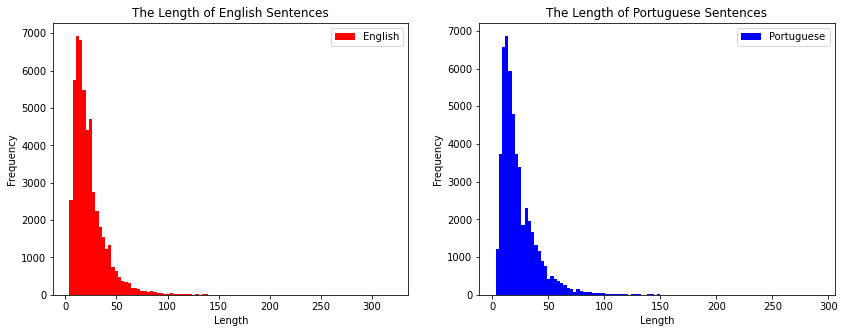

In [9]:
fig, ax = plt.subplots(1,2)

ax[0].hist(en_length_list, bins=100, color="red", label="English")
ax[1].hist(pt_length_list, bins=100, color="blue", label="Portuguese")
ax[0].legend()
ax[1].legend()
ax[0].set_title("The Length of English Sentences")
ax[1].set_title("The Length of Portuguese Sentences")
ax[0].set_xlabel("Length")
ax[1].set_xlabel("Length")
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")

fig.set_size_inches(14, 5)
plt.show()

In [10]:
MAX_LENGTH = 128

In [ ]:
en_tokenizer.vocab

<tf.Variable 'Variable:0' shape=(7010,) dtype=string, numpy=
array([b'[PAD]', b'[UNK]', b'[START]', ..., b'##\xe2\x80\x99',
       b'##\xe2\x99\xaa', b'##\xe2\x99\xab'], dtype=object)>

In [14]:
def pad_dataset(dataset):
  new_dataset = []

  for pt_data, en_data in dataset.batch(1):
    en_tokens = en_tokenizer.tokenize(en_data).numpy()[0]
    pt_tokens = pt_tokenizer.tokenize(pt_data).numpy()[0]

    if len(en_tokens) > MAX_LENGTH or len(pt_tokens) > MAX_LENGTH:continue

    en_tokens = np.concatenate([en_tokens, np.zeros(MAX_LENGTH - len(en_tokens), np.int64)])
    pt_tokens = np.concatenate([pt_tokens, np.zeros(MAX_LENGTH - len(pt_tokens), np.int64)])

    new_dataset.append({"en": en_tokens, "pt": pt_tokens})

  new_dataset = pd.DataFrame(new_dataset)  
  return new_dataset

In [16]:
new_dataset = pad_dataset(train_dataset)

# Positional Encoding

In [22]:
def positional_encoding(position, d_model):
  encoding = np.zeros(d_model)

  for j in range(d_model):
    i = j//2
    angle = position/(10000**(2*i/d_model))

    if j%2==0:
      encoding[j] = np.sin(angle)
    else:
      encoding[j] = np.cos(angle)

  return encoding

In [30]:
positional_encoding_list = []
d_model = 512

for position in range(MAX_LENGTH):
  positional_encoding_list.append(positional_encoding(position, d_model))

# Transformer FeedForward

In [35]:
class TransformerFeedForward(Layer):
  def __init__(self, dff, d_model):
    self.model = Sequential([
                             Dense(dff, activation="relu"),
                             Dense(d_model)

    ])
  
  def call(self, inputs):
    self.model.call(inputs)

# Encoder

In [ ]:
class Encoder(Layer):
  def __init__(self, d_model, num_heads, dff):
    self.super().__init__()

    self.multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.feedforward = TransformerFeedForward(dff=dff, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)

  def call(self, x, mask):
    attention_output = self.multi_head_attention(x, x, x, mask)[0]

    normal_output = self.normal_1(attention_output + x)

    feedforward_output = self.feedforward(normal_output)

    output = self.normal_2(feedforward_output + x) 

    return output

# Decoder

In [ ]:
class Decoder(Layer):
  def __init__(self, num_heads, dff, d_model):
    self.super().__init__()

    self.multi_head_attention_1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.multi_head_attention_2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    
    self.feedforward = TransformerFeedForward(dff=dff, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)
    self.normal_3 = LayerNormalization(epsilon=1e-6)

  def call(self, x, encoder_output, look_ahead_mask, padding_mask):
    attention_output_1, attention_weights_1 = self.multi_head_attention_1(x, x, x, look_ahead_mask)

    normal_output_1 = self.normal_1(attention_output_1 + x)

    attention_output_2, attention_weights_2 = self.multi_head_attention_2(encoder_output, encoder_output, normal_output_1, padding_mask)

    normal_output_2 = self.normal_2(attention_output_2 + normal_output_1)

    feedforward_output = self.feedforward(normal_output_2)

    normal_output_3 = self.normal_3(feedforward_output + normal_output_2)

    return normal_output_3, attention_weights_1, attention_weights_2